## Brain Community Detection

##### DQM

In [1]:
from QHyper.problems.brain_community_detection import (
    BrainCommunityDetectionProblem,
)


num_cases = 4
path = "../QHyper/problems/brain_community_data"
data_name = "Edge_AAL90_Binary"
brain_problem = BrainCommunityDetectionProblem(path, data_name, num_cases)
print(brain_problem.variables)

(x0, x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x13, x14, x15, x16, x17, x18, x19, x20, x21, x22, x23, x24, x25, x26, x27, x28, x29, x30, x31, x32, x33, x34, x35, x36, x37, x38, x39, x40, x41, x42, x43, x44, x45, x46, x47, x48, x49, x50, x51, x52, x53, x54, x55, x56, x57, x58, x59, x60, x61, x62, x63, x64, x65, x66, x67, x68, x69, x70, x71, x72, x73, x74, x75, x76, x77, x78, x79, x80, x81, x82, x83, x84, x85, x86, x87, x88, x89)


<class 'networkx.utils.decorators.argmap'> compilation 9:5: FutureWarning: modularity_matrix will return a numpy array instead of a matrix in NetworkX 3.0.


In [2]:
from QHyper.solvers.dqm import DQM


brain_dqm = DQM(brain_problem, 5)
brain_sampleset = brain_dqm.solve_from_graph()

In [3]:
import numpy as np


sample = brain_sampleset.first.sample
energy = brain_sampleset.first.energy
run_time = (brain_sampleset.info["run_time"]) * 0.001

communities = []
for k in range(brain_problem.num_cases):
    comm = []
    for i in sample:
        if sample[i] == k:
            comm.append(i)
    communities.append(set(comm))

counts = np.zeros(brain_problem.num_cases)
for s in sample.values():
    counts[s] += 1

print(sample)

{0: 1, 1: 1, 2: 3, 3: 3, 4: 3, 5: 3, 6: 3, 7: 3, 8: 3, 9: 3, 10: 3, 11: 3, 12: 3, 13: 3, 14: 3, 15: 3, 16: 1, 17: 1, 18: 3, 19: 1, 20: 2, 21: 2, 22: 3, 23: 3, 24: 3, 25: 3, 26: 3, 27: 3, 28: 1, 29: 1, 30: 3, 31: 3, 32: 1, 33: 1, 34: 0, 35: 0, 36: 2, 37: 2, 38: 2, 39: 2, 40: 2, 41: 2, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 1, 57: 1, 58: 0, 59: 0, 60: 3, 61: 3, 62: 1, 63: 1, 64: 3, 65: 3, 66: 0, 67: 0, 68: 1, 69: 1, 70: 2, 71: 2, 72: 2, 73: 2, 74: 2, 75: 2, 76: 2, 77: 2, 78: 1, 79: 1, 80: 1, 81: 1, 82: 1, 83: 1, 84: 3, 85: 3, 86: 2, 87: 2, 88: 3, 89: 3}


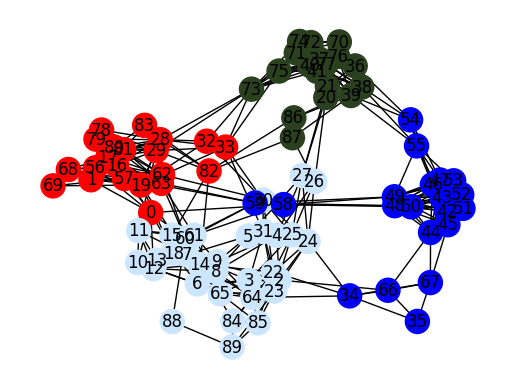

In [4]:
output_folder = "./demo_output"
results = communities, run_time, energy, counts, sample
brain_problem.plot_results(output_folder, results)